# TASK A: Image Retrieval with Pre-Trained Image Classification Model

In [1]:
import os
import cv2
import torch
import torchvision


import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle as pkl
import torchvision.transforms as transforms

from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from tqdm import tqdm
from sklearn.metrics import average_precision_score, precision_recall_curve, PrecisionRecallDisplay, confusion_matrix
from sklearn.preprocessing import OneHotEncoder, LabelBinarizer, label_binarize
from cf_matrix import *
from faiss_custom import FaissRetrieval

Initialize Image DataLoader 

In [2]:
DATASET = '../../MIT_split'
BATCH_SIZE = 1
CLASSES = ['coast','forest','highway','inside_city','mountain','Opencountry','street','tallbuilding']

# Dataset Transformations
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Folders
train_dataset = torchvision.datasets.ImageFolder(os.path.join(DATASET,'train'), transform=transform)
test_dataset = torchvision.datasets.ImageFolder(os.path.join(DATASET,'test'), transform=transform)

# Paths map(list, zip(*lot))
train_images, train_labels = map(list, zip(*[(path, label) for path, label in train_dataset.imgs]))
test_images, test_labels = map(list, zip(*[(path, label) for path, label in test_dataset.imgs]))

# Load Images
train_images = np.array([cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB) for path in tqdm(train_images)])
test_images = np.array([cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB) for path in tqdm(test_images)])

# Images shape
print(f"Train Images : {train_images.shape}")
print(f"Test Images : {test_images.shape}")

100%|██████████| 807/807 [00:02<00:00, 300.62it/s]


Train Images : (1881, 256, 256, 3)
Test Images : (807, 256, 256, 3)


### Retrieval with FAISS

First we init and train FAISS

In [3]:
faiss = FaissRetrieval(dataset = DATASET, train = (1881, 2048), test = (807, 2048),
                       train_dir = "../features/train_features_resnet50.pkl", 
                       test_dir = "../features/test_features_resnet50.pkl", similarity = 5)

faiss.train()

Reading Data...
Train Images : (1881, 256, 256, 3)
Test Images : (807, 256, 256, 3)
Getting Embeddings...
Starting Training...


WARNING clustering 1881 points to 256 centroids: please provide at least 9984 training points
WARNING clustering 1881 points to 256 centroids: please provide at least 9984 training points
WARNING clustering 1881 points to 256 centroids: please provide at least 9984 training points
WARNING clustering 1881 points to 256 centroids: please provide at least 9984 training points
WARNING clustering 1881 points to 256 centroids: please provide at least 9984 training points
WARNING clustering 1881 points to 256 centroids: please provide at least 9984 training points
WARNING clustering 1881 points to 256 centroids: please provide at least 9984 training points
WARNING clustering 1881 points to 256 centroids: please provide at least 9984 training points
WARNING clustering 1881 points to 256 centroids: please provide at least 9984 training points
WARNING clustering 1881 points to 256 centroids: please provide at least 9984 training points
WARNING clustering 1881 points to 256 centroids: please prov

Training: DONE
Adding IDs: DONE


We load and process embeddings

In [4]:
# Load Saved Features and Flatten
train_embedding_features = pkl.load(open("../features/train_features_resnet50.pkl", "rb"))
train_embedding_features = np.array([item for sublist in train_embedding_features for item in sublist]).reshape((1881, 2048))
test_embedding_features = pkl.load(open("../features/test_features_resnet50.pkl", "rb"))
test_embedding_features = np.array([item for sublist in test_embedding_features for item in sublist]).reshape((807, 2048))

# Normalize
normalizer = StandardScaler() # Normalize Data
train_embedding_features = normalizer.fit_transform(train_embedding_features)
test_embedding_features = normalizer.transform(test_embedding_features)

# Dim Reduc.
pca = PCA(n_components=64) 
train_embedding_features = pca.fit_transform (train_embedding_features)
test_embedding_features = pca.transform (test_embedding_features)

We show qualitative examples

In [5]:
def retrieve_top_k(query, k):
    results = faiss.search_by_image(query.reshape((1, train_embedding_features.shape[1])), k = k)[0]
    distances, indices = results["scores"], results["neighbors"]
    top, labels = map(list, zip(*[(train_images[indices[0][i]], train_labels[indices[0][i]]) for i in range(k)]))
    return (top, labels)

# Plot top K and query
def plot_top_3(query, top):
    fig, axs = plt.subplots(2, 2, figsize=(15,15))
    axs[0, 0].imshow(query[0])
    axs[0, 0].set_title(f'Query Image || Class: {query[1]}')
    axs[0, 0].axis('off')
    axs[0, 1].imshow(top[0][0])
    axs[0, 1].set_title(f'Top 1 || Class: {top[1][0]}')
    axs[0, 1].axis('off')
    axs[1, 0].imshow(top[0][1])
    axs[1, 0].set_title(f'Top 2 || Class: {top[1][1]}')
    axs[1, 0].axis('off')
    axs[1, 1].imshow(top[0][2])
    axs[1, 1].set_title(f'Top 3 || Class: {top[1][2]}')
    axs[1, 1].axis('off')
    plt.axis("off")
    plt.show()

Evaluating with Train Data

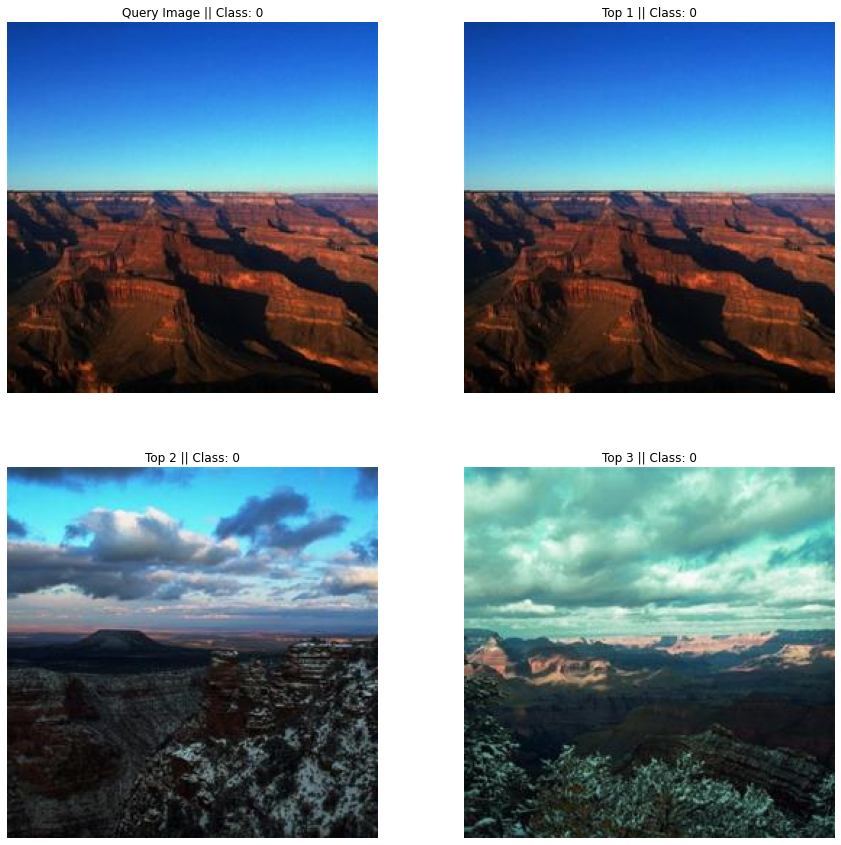

In [6]:
top = retrieve_top_k(query = train_embedding_features[5], k = 3)
plot_top_3((train_images[5], train_labels[5]), top)

Evaluating with Test Data

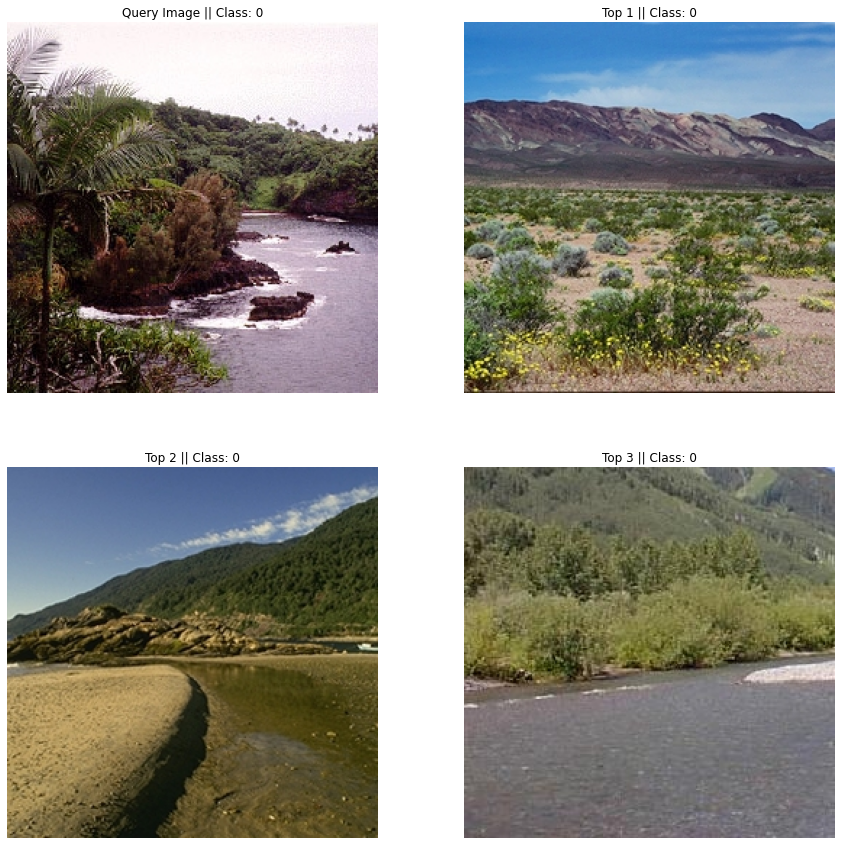

In [7]:
top = retrieve_top_k(query = test_embedding_features[80], k = 3)
plot_top_3((test_images[80], test_labels[80]), top)

Now some Metrics. [Confusion Matrix code from here](https://github.com/DTrimarchi10/confusion_matrix)

In [8]:
def evaluate_ap(data, labels, k):
    # Predict
    predicted = np.array([retrieve_top_k(query = query, k = k)[1][:k] for query, classes in zip(data, labels)])
    real = np.array([[labels[i] for _ in range(k)] for i in range(len(data))])
    
    # Encode
    encoder = OneHotEncoder()
    real = encoder.fit_transform(real).toarray()
    predicted = encoder.transform(predicted).toarray()
    
    # Metrics
    ap = average_precision_score(predicted, real)
    
    #Info
    print(f"AP@k={k}: {ap:.4f}")
    

def evaluate_precision_recall(data, labels, k):
    # Predict
    predicted = np.array([retrieve_top_k(query = query, k = k)[1][:k] for query, classes in zip(data, labels)])
    real = np.array([[labels[i] for _ in range(k)] for i in range(len(data))])
    
    # Encode
    encoder = OneHotEncoder()
    real = encoder.fit_transform(real).toarray()
    predicted = encoder.transform(predicted).toarray()
    
    # precision recall curve
    precision = dict()
    recall = dict()
    for i in range(8):
        precision[i], recall[i], _ = precision_recall_curve(real[:, i], predicted[:, i])
        plt.plot(recall[i], precision[i], lw=2, label='class {}'.format(i))

    plt.xlabel("recall")
    plt.ylabel("precision")
    plt.legend(loc="best")
    plt.title(f"precision vs. recall curve @k={k}")
    plt.show()

    
def evaluate_cm(data, labels, k):
    # Predict
    predicted = np.array([retrieve_top_k(query = query, k = k)[1][:k] for query, classes in zip(data, labels)])
    real = np.array([[labels[i] for _ in range(k)] for i in range(len(data))])
    
    # Confusion Matrix
    cf_matrix = confusion_matrix([[item] for sublist in real for item in sublist],
                                 [[item] for sublist in predicted for item in sublist])
    # Encode
    encoder = OneHotEncoder()
    real = encoder.fit_transform(real).toarray()
    predicted = encoder.transform(predicted).toarray()
    
    make_confusion_matrix(cf_matrix, figsize=(8,6), cbar=False)
    plt.title(f"Confusion Matrix @k={k}")
    plt.show()

In [9]:
evaluate_ap(test_embedding_features, test_labels, k=1)
evaluate_ap(test_embedding_features, test_labels, k=3)
evaluate_ap(test_embedding_features, test_labels, k=5)
evaluate_ap(test_embedding_features, test_labels, k=10)

AP@k=1: 0.8001
AP@k=3: 0.7958
AP@k=5: 0.7785
AP@k=10: 0.7575


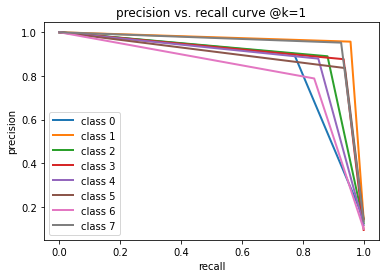

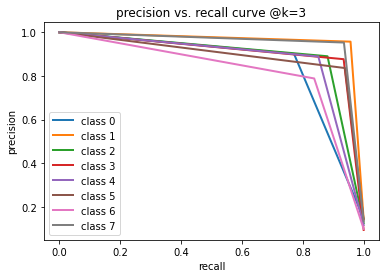

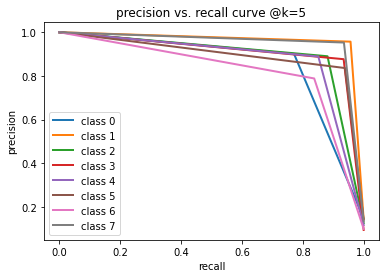

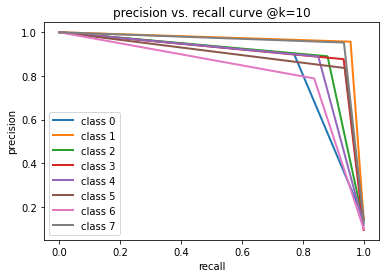

In [10]:
evaluate_precision_recall(test_embedding_features, test_labels, k=1)
evaluate_precision_recall(test_embedding_features, test_labels, k=3)
evaluate_precision_recall(test_embedding_features, test_labels, k=5)
evaluate_precision_recall(test_embedding_features, test_labels, k=10)

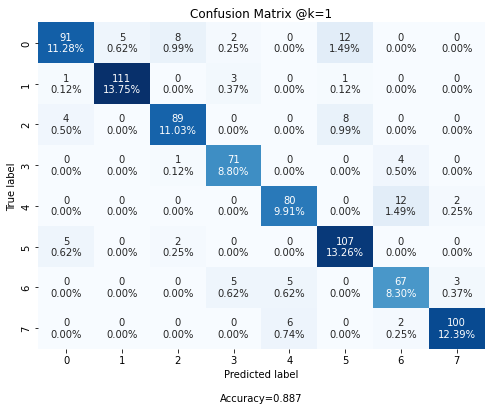

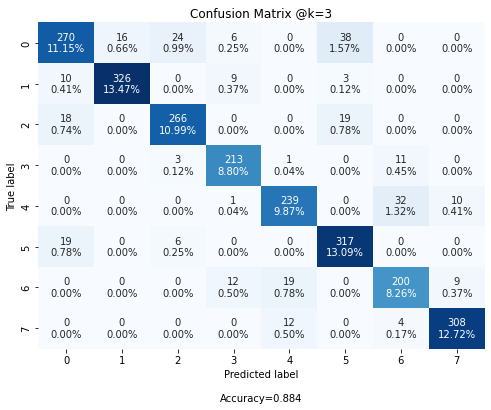

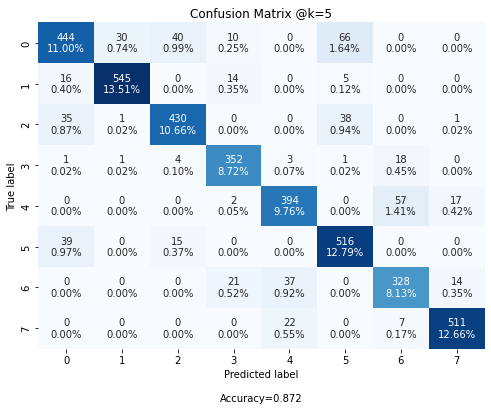

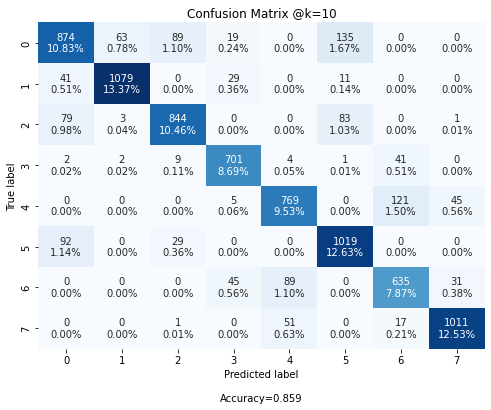

In [11]:
evaluate_cm(test_embedding_features, test_labels, k=1)
evaluate_cm(test_embedding_features, test_labels, k=3)
evaluate_cm(test_embedding_features, test_labels, k=5)
evaluate_cm(test_embedding_features, test_labels, k=10)